# KX Fixed Income Bond Screener for ICE® Data Accelerator API Examples

This notebook demonstrates calling the FSI Library APIs via REST for the KX Fixed Income Bond Screener for ICE® Data Accelerator. You will need a running instance of kdb Insights Enterprise with the Accelerator deployed.

kdb Accelerators are packages for kdb products that address typical industry use cases. Using an Accelerator allows you to leapfrog the first phases of a project or Insights implementation, skipping common boilerplate or initial effort and jumping straight to value adding work. They are a customization-first approach to developing on kdb products, helping you learn and unlock the value of KX products faster.

You can read more about the Accelerator in the [Fixed Income Bond Screener Introduction](https://code.kx.com/insights/accelerators/fsi/ice-fi-introduction.html).


---
### Imports, Constants, Helper Function, & Authentication

In [1]:
import os
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timezone, timedelta
from requests_oauth2client import OAuth2Client, OAuth2ClientCredentialsAuth
from getpass import getpass

You should edit the constants below to reflect your particular kdb Insights instance details. You will be prompted for a Client and Secret.

In [2]:
# Constants - set these as appropriate
INSIGHTS_HOST   = '<HOST>' # Your Insights Enterprise hostname
INSIGHTS_REALM  = '<REALM>' # Your Insights realm, typically 'insights'
INSIGHTS_CLIENT = input("kdb Insights client: ")           # Your insights client (service account name)
INSIGHTS_SECRET = getpass("kdb Insights client secret: ")  # Your insights secret

In [3]:
# Authentication
oauth2client = OAuth2Client(
    token_endpoint='https://' + INSIGHTS_HOST + '/auth/realms/' + INSIGHTS_REALM + '/protocol/openid-connect/token',
    auth=(INSIGHTS_CLIENT, INSIGHTS_SECRET))
oauth2cc = OAuth2ClientCredentialsAuth(oauth2client, scope='roles')

---
## Fixed Income Drilldown
---

### Treasury Benchmarks

In [4]:
# Build arguments dictionary
args = {
  "table": "Quote",
  "startTS": (datetime.today()+timedelta(days=-7)).strftime("%Y.%m.%dD00:00:00.000"),
  "endTS": (datetime.today()+timedelta(days=1)).strftime("%Y.%m.%dD00:00:00.000"),
  "idList": ["B:US3M", "B:US6M", "B:US12M", "B:US2Y", "B:US3Y", "B:US5Y", "B:US7Y", "B:US10Y", "B:US20Y", "B:US30Y"],
  "granularity": "1",
  "granularityUnit": "day",
  "analytics": ["lastBidYield", "lastEventTimestamp"],
  "bondPlot": 'treasuryBenchmark',
  "decPlaces": '3',
  "scope": {"assembly": "fsi-app-ice-fi"}
}

# Make request & extract header & payload
r = requests.post('https://' + INSIGHTS_HOST + '/servicegateway/fsi/getStats', auth=oauth2cc, json=args)
header = json.loads(r.text)['header']
payloadTreasuryBenchmarks = json.loads(r.text)['payload']

It is best practice when calling the APIs is to always check the header for errors - [code.kx.com](https://code.kx.com) has more information kdb Insights Enterprise [response codes and errors](https://code.kx.com/insights/api/database/api/codes.html#return-code), and also has an [Accelerators API Error Glossary](https://code.kx.com/insights/accelerators/fsi/error-glossary.html).

In [5]:
header

{'rcvTS': '2024-09-20T16:59:05.506000000',
 'corr': 'd267d8af-f1d7-459e-aff3-236f904c592f',
 'protocol': 'gw',
 'entID': None,
 'logCorr': 'd267d8af-f1d7-459e-aff3-236f904c592f',
 'client': ':10.244.3.34:5050',
 'http': 'json',
 'api': '.fsi.getStats',
 'userName': 'azuredemo-client',
 'userID': '9ce02b79-55e6-4b7a-88ac-f472b27e6d80',
 'retryCount': 0,
 'to': '2024-09-20T17:00:05.506000000',
 'agg': ':10.244.9.6:5070',
 'pvVer': 152,
 'rpID': 0,
 'refVintage': 386881986745,
 'startTS': '2024-09-20T16:50:00.000000000',
 'endTS': '2024-09-21T00:00:00.000000000',
 'rc': 0,
 'ac': 0,
 'ai': ''}

In [6]:
dfTreasuryBenchmarks = pd.DataFrame(payloadTreasuryBenchmarks)
dfTreasuryBenchmarks

,,Bid Yld,Prev Yld,Chg,Time
0,B:US3M,4.690,4.887,None,16:54:41
1,B:US6M,4.481,4.640,None,16:54:43
2,B:US12M,3.938,4.023,None,16:57:42
3,B:US2Y,3.570,3.593,None,16:59:02
4,B:US3Y,3.456,3.444,None,16:58:50
5,B:US5Y,3.474,3.438,None,16:58:52
6,B:US7Y,3.586,3.535,None,16:59:04
7,B:US10Y,3.719,3.657,None,16:58:54
8,B:US20Y,4.106,4.051,None,16:58:49
9,B:US30Y,4.066,3.983,None,16:59:02


---

### Historical Spreads

In [7]:
# Build arguments dictionary
args = {
  "table": "Quote",
  "startTS": (datetime.today()+timedelta(days=-30)).strftime("%Y.%m.%dD00:00:00.000"),
  "endTS": (datetime.today()+timedelta(days=1)).strftime("%Y.%m.%dD00:00:00.000"),
  "granularity": 1,
  "granularityUnit": 'day',
  "analytics": ['lastBidSpread', 'lastSrcSys'],
  "fiPlot": "histSpreadIG",
  "fiPlotFilter": "enlist (=;`lastSrcSys;enlist `1330)",
  "scope": {"assembly": "fsi-app-ice-fi"}
}

# Make request & extract header & payload
r = requests.post('https://' + INSIGHTS_HOST + '/servicegateway/fsi/getCurrBars', auth=oauth2cc, json=args)
header = json.loads(r.text)['header']
payloadHistSpreadsIG = json.loads(r.text)['payload']

In [8]:
dfHistSpreadsIG = pd.DataFrame(payloadHistSpreadsIG)
dfHistSpreadsIG.tail()

,eventTimestamp,bidSpread
18,2024-09-16,141.9678
19,2024-09-17,141.5939
20,2024-09-18,139.8769
21,2024-09-19,137.1981
22,2024-09-20,145.4096


#### Historical Spreads - Instrument Sector

In [9]:
# Build arguments dictionary
args = {
  "table": "Quote",
  "startTS": (datetime.today()+timedelta(days=-30)).strftime("%Y.%m.%dD00:00:00.000"),
  "endTS": (datetime.today()+timedelta(days=1)).strftime("%Y.%m.%dD00:00:00.000"),
  "granularity": 1,
  "granularityUnit": 'day',
  "analytics": 'lastBidSpread',
  "fiPlot": 'histSpreadCD',
  "ref": "Instrument",
  "refFilter": ["""(enlist `Instrument)!(enlist ((=;`srcSys;`1330);(in;`instrumentSector;enlist ("," vs "Consumer Discretionary,Energy,Industrials,Materials,Utilities"))))"""],
  "scope": {"assembly": "fsi-app-ice-fi"}
}

# Make request & extract header & payload
r = requests.post('https://' + INSIGHTS_HOST + '/servicegateway/fsi/getCurrBars', auth=oauth2cc, json=args)
header = json.loads(r.text)['header']
payloadHistSpreadsCD = json.loads(r.text)['payload']

In [10]:
dfHistSpreadsCD = pd.DataFrame(payloadHistSpreadsCD)
dfHistSpreadsCD.tail()

,eventTimestamp,Consumer Discretionary,Energy,Industrials,Materials,Utilities
18,2024-09-16,162.2399,125.7931,102.53920,122.2182,114.8736
19,2024-09-17,166.7889,124.6217,102.00300,118.2075,113.7301
20,2024-09-18,166.3420,122.8676,100.72210,115.6772,112.4035
21,2024-09-19,157.7940,120.0804,98.62528,112.9180,109.8140
22,2024-09-20,160.2613,119.6039,101.15250,110.9900,110.8065


#### Historical Spreads Chart

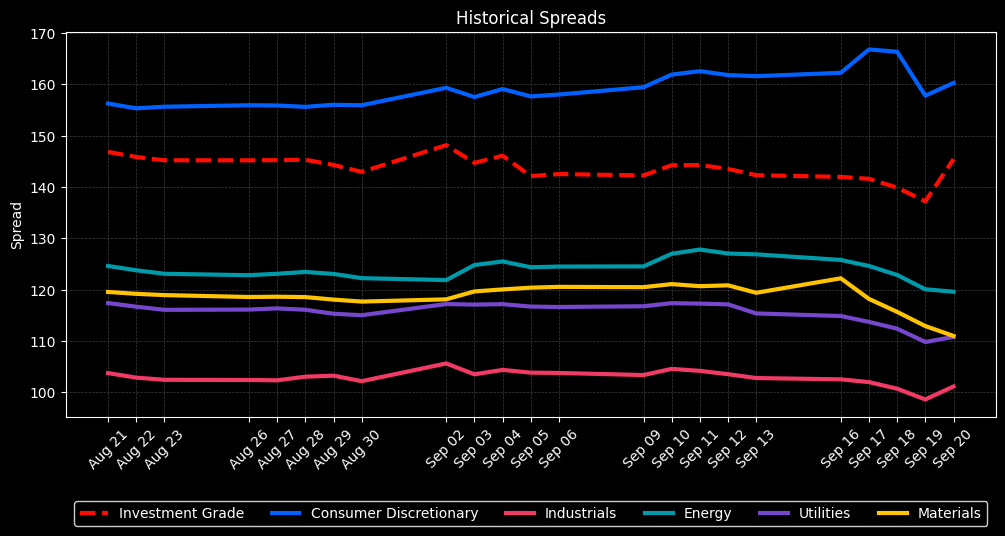

In [11]:
plt.style.use('dark_background')

dfHistSpreadsIG['eventTimestamp'] = pd.to_datetime(dfHistSpreadsIG['eventTimestamp'])
dfHistSpreadsCD['eventTimestamp'] = pd.to_datetime(dfHistSpreadsCD['eventTimestamp'])

plt.figure(figsize=(12, 5))

plt.plot(dfHistSpreadsIG['eventTimestamp'], dfHistSpreadsIG['bidSpread'], label='Investment Grade', color='#ff0d00', linewidth=3, linestyle='--')
plt.plot(dfHistSpreadsCD['eventTimestamp'], dfHistSpreadsCD['Consumer Discretionary'], label='Consumer Discretionary', color='#0061ff', linewidth=3)
plt.plot(dfHistSpreadsCD['eventTimestamp'], dfHistSpreadsCD['Industrials'], label='Industrials', color='#f23a66', linewidth=3)
plt.plot(dfHistSpreadsCD['eventTimestamp'], dfHistSpreadsCD['Energy'], label='Energy', color='#009bab', linewidth=3)
plt.plot(dfHistSpreadsCD['eventTimestamp'], dfHistSpreadsCD['Utilities'], label='Utilities', color='#7647cc', linewidth=3)
plt.plot(dfHistSpreadsCD['eventTimestamp'], dfHistSpreadsCD['Materials'], label='Materials', color='#ffc300', linewidth=3)

plt.title('Historical Spreads')
plt.ylabel('Spread')
plt.grid(True, which='both', color='#3d3d3d', linestyle='--', linewidth=0.5)
plt.xticks(dfHistSpreadsIG['eventTimestamp'], dfHistSpreadsIG['eventTimestamp'].dt.strftime('%b %d'), rotation=45)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -.2), ncol=999, framealpha=1, )

plt.show()

---

### Spread Change

In [12]:
# Build arguments dictionary
args = {
  "table": "Quote",
  "startTS": (datetime.today()+timedelta(days=-30)).strftime("%Y.%m.%dD00:00:00.000"),
  "endTS": (datetime.today()+timedelta(days=1)).strftime("%Y.%m.%dD00:00:00.000"),
  "granularity": 1,
  "granularityUnit": "day",
  "analytics": ["lastBidSpread", "lastSrcSys"],
  "fiPlot": "spreadChangeIG",
  "fiPlotFilter": "enlist (=;`lastSrcSys;enlist `1330)",
  "scope": {"assembly": "fsi-app-ice-fi"}
}

# Make request & extract header & payload
r = requests.post('https://' + INSIGHTS_HOST + '/servicegateway/fsi/getCurrBars', auth=oauth2cc, json=args)
header = json.loads(r.text)['header']
payloadSpreadChangeIG = json.loads(r.text)['payload']

In [13]:
dfSpreadChangeIG = pd.DataFrame(payloadSpreadChangeIG)
dfSpreadChangeIG.tail()

,eventDateChange,sprdChg
18,4D Chg,-3.441675
19,3D Chg,-3.815622
20,2D Chg,-5.532547
21,1D Chg,-8.211387
22,0D Chg,0.000000


#### Spread Change Source

In [14]:
# Build arguments dictionary
args = {
  "table": "Quote",
  "startTS": (datetime.today()+timedelta(days=-30)).strftime("%Y.%m.%dD00:00:00.000"),
  "endTS": (datetime.today()+timedelta(days=1)).strftime("%Y.%m.%dD00:00:00.000"),
  "granularity": 1,
  "granularityUnit": "day",
  "analytics": ["lastBidSpread"],
  "fiPlot": "spreadChangeCD",
  "ref": "Instrument",
  "refFilter": ["""(enlist `Instrument)!(enlist ((=;`srcSys;`1330);(in;`instrumentSector;enlist ("," vs "Consumer Discretionary,Energy,Industrials,Materials,Utilities"))))"""],
  "scope": {"assembly": "fsi-app-ice-fi"}
}

# Make request & extract header & payload
r = requests.post('https://' + INSIGHTS_HOST + '/servicegateway/fsi/getCurrBars', auth=oauth2cc, json=args)
header = json.loads(r.text)['header']
payloadSpreadChangeCD = json.loads(r.text)['payload']

In [15]:
dfSpreadChangeCD = pd.DataFrame(payloadSpreadChangeCD)
dfSpreadChangeCD.tail()

,eventTimestamp,Consumer Discretionary,Energy,Industrials,Materials,Utilities
18,4D Chg,1.974402,6.189388,1.385408,11.227590,4.066758
19,3D Chg,6.523442,5.017969,0.849237,7.216924,2.923291
20,2D Chg,6.076502,3.263859,-0.431691,4.686649,1.596710
21,1D Chg,-2.471420,0.476677,-2.528492,1.927394,-0.992770
22,0D Chg,0.000000,0.000000,0.000000,0.000000,0.000000


#### Spread Change Plot

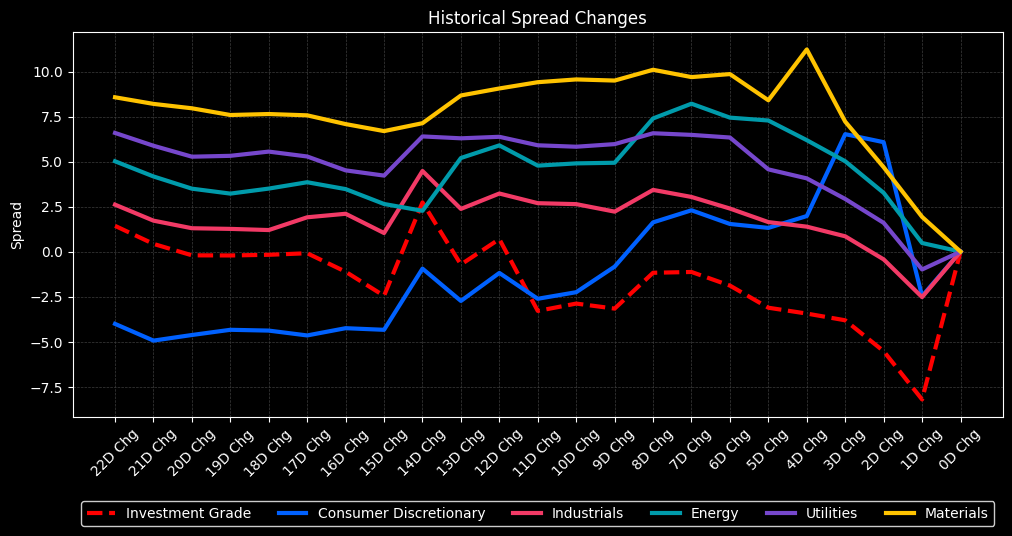

In [16]:
plt.style.use('dark_background')
plt.figure(figsize=(12, 5))

plt.plot(dfSpreadChangeIG['eventDateChange'], dfSpreadChangeIG['sprdChg'], label='Investment Grade', color='red', linewidth=3, linestyle='--')
plt.plot(dfSpreadChangeCD['eventTimestamp'], dfSpreadChangeCD['Consumer Discretionary'], label='Consumer Discretionary', color='#0061ff', linewidth=3)
plt.plot(dfSpreadChangeCD['eventTimestamp'], dfSpreadChangeCD['Industrials'], label='Industrials', color='#f23a66', linewidth=3)
plt.plot(dfSpreadChangeCD['eventTimestamp'], dfSpreadChangeCD['Energy'], label='Energy', color='#009bab', linewidth=3)
plt.plot(dfSpreadChangeCD['eventTimestamp'], dfSpreadChangeCD['Utilities'], label='Utilities', color='#7647cc', linewidth=3)
plt.plot(dfSpreadChangeCD['eventTimestamp'], dfSpreadChangeCD['Materials'], label='Materials', color='#ffc300', linewidth=3)

plt.title('Historical Spread Changes')
plt.ylabel('Spread')
plt.grid(True, which='both', color='#3d3d3d', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -.2), ncol=999, framealpha=1, )

plt.show()

---

### Sector Data

In [17]:
# Build arguments dictionary
args = {
  "table": "Quote",
  "startTS": (datetime.today()+timedelta(days=-30)).strftime("%Y.%m.%dD00:00:00.000"),
  "endTS": (datetime.today()+timedelta(days=1)).strftime("%Y.%m.%dD00:00:00.000"),
  "granularity": 1,
  "granularityUnit": "day",
  "analytics": 'lastBidSpread',
  "fiPlot": "sectorData",
  "ref": "Instrument",
  "refFilter": ["""(enlist `Instrument)!(enlist ((=;`srcSys;`1330);(in;`instrumentSector;enlist ("," vs "Consumer Discretionary,Financials,Industrials"))))"""],
  "scope": {"assembly": "fsi-app-ice-fi"}
}

# Make request & extract header & payload
r = requests.post('https://' + INSIGHTS_HOST + '/servicegateway/fsi/getCurrBars', auth=oauth2cc, json=args)
header = json.loads(r.text)['header']
payloadSectorData = json.loads(r.text)['payload']


In [23]:
dfSectorData = pd.DataFrame(payloadSectorData)
dfSectorData.head()

,Sector,Cusip,S&P,Ticker,Coupon,Maturity Date,Yrs to Mty,Description,Bid Sprd,Prev Bid Sprd,1 Day Diff,5 Day Diff,15 Day Diff,30 Day Diff,instrumentID
0,Consumer Discretionary,000170AA8,,AMHCC,0.000,2024-12-01,0.197260,A&M HOSP CONVENTION CTR,NaN,NaN,NaN,NaN,NaN,None,B:000170AA8
1,Consumer Discretionary,00036AAA3,,AARP,0.000,2031-05-01,6.613699,AARP,NaN,NaN,NaN,NaN,NaN,None,B:00036AAA3
2,Consumer Discretionary,00036AAB1,,AARP,7.500,2031-05-01,6.613699,AARP,267.7751,258.4985,-9.2766,5.7130,-5.2709,None,B:00036AAB1
3,Industrials,00037BAC6,,ABBNVX,4.375,2042-05-08,17.641100,ABB FINANCE USA INC,71.0308,71.4690,0.4382,3.1981,-3.3022,None,B:00037BAC6
4,Industrials,00037BAF9,,ABBNVX,3.800,2028-04-03,3.536986,ABB FINANCE USA INC,31.6829,31.8752,0.1923,-2.3429,-10.1511,None,B:00037BAF9


---

### Ratings Averages data

In [19]:
# Build arguments dictionary
args = {
  "table": "Quote",
  "startTS": (datetime.today()+timedelta(days=-30)).strftime("%Y.%m.%dD00:00:00.000"),
  "endTS": (datetime.today()+timedelta(days=1)).strftime("%Y.%m.%dD00:00:00.000"),
  "granularity": 1,
  "granularityUnit": "day",
  "analytics": ["lastBidSpread"],
  "fiPlot": "sectorAvgData",
  "ref": "Instrument",
  "refFilter": ["""(enlist `Instrument)!(enlist ((=;`srcSys;`1330);(in;`instrumentSector;enlist ("," vs "Consumer Discretionary,Financials,Industrials"))))"""],
  "scope": {"assembly": "fsi-app-ice-fi"}
}

# Make request & extract header & payload
r = requests.post('https://' + INSIGHTS_HOST + '/servicegateway/fsi/getCurrBars', auth=oauth2cc, json=args)
header = json.loads(r.text)['header']
payloadSectorAvgData = json.loads(r.text)['payload']

In [20]:
dfSectorAvgData = pd.DataFrame(payloadSectorAvgData)
print("Ratings Averages")
dfSectorAvgData.tail(20)

Ratings Averages


,All Ratings,Current,Prev,1D Chg,5D Chg,15D Chg,30D Chg,spLongRating
38,12Y+,97.43675,97.63507,0.198321,8.529979,5.462740,None,
39,BBB+,NaN,NaN,NaN,NaN,NaN,None,yes
40,0-5Y,83.64624,83.83743,0.191195,5.411803,-0.495389,None,
41,5-12Y,113.58090,113.41740,-0.163513,6.679102,4.245810,None,
42,12Y+,108.36760,107.86560,-0.502016,7.688260,7.115912,None,
43,BBB,NaN,NaN,NaN,NaN,NaN,None,yes
44,0-5Y,93.38945,93.56990,0.180442,5.868081,-1.463451,None,
45,5-12Y,134.54440,134.87710,0.332657,8.753009,4.846090,None,
46,12Y+,133.41220,129.54130,-3.870892,9.115879,4.739092,None,
47,BBB-,NaN,NaN,NaN,NaN,NaN,None,yes


---

### Largest One-day Change Wider/Tighter data

In [21]:
# Build arguments dictionary
args = {
  "table": "Quote",
  "startTS": (datetime.today()+timedelta(days=-30)).strftime("%Y.%m.%dD00:00:00.000"),
  "endTS": (datetime.today()+timedelta(days=1)).strftime("%Y.%m.%dD00:00:00.000"),
  "granularity": 1,
  "granularityUnit": "day",
  "analytics": ["lastBidSpread"],
  "fiPlot": "sectorLrgstChg",
  "decPlaces": 3,
  "ref": "Instrument",
  "refFilter": ["""(enlist `Instrument)!(enlist ((=;`srcSys;`1330);(in;`instrumentSector;enlist ("," vs "Consumer Discretionary,Energy,Industrials, Materials, Utilities"))))"""],
  "scope": {"assembly": "fsi-app-ice-fi"}
}

# Make request & extract header & payload
r = requests.post('https://' + INSIGHTS_HOST + '/servicegateway/fsi/getCurrBars', auth=oauth2cc, json=args)
header = json.loads(r.text)['header']
payloadLargestSpreadChg = json.loads(r.text)['payload']

In [22]:
dfLargestSpreadChg = pd.DataFrame(payloadLargestSpreadChg)
print("Largest One-Day Chg Wider/Tighter")
dfLargestSpreadChg

Largest One-Day Chg Wider/Tighter


,Issuer,Coupon,Maturity Date,Change,CUSIP,Sector,highlight
0,Wider,NaN,,NaN,,,True
1,ALLE,3.200,2024-10-01,241.162,01748NAD6,Industrials,False
2,ET,9.000,2024-11-01,116.808,866762AK3,Energy,False
3,PWR,0.950,2024-10-01,83.245,74762EAG7,Industrials,False
4,SWK,4.000,2060-03-15,76.217,854502AM3,Industrials,False
5,GM,1.200,2024-11-20,74.893,37046AET8,Consumer Discretionary,False
6,Tighter,NaN,,NaN,,,True
7,RTX,7.500,2026-04-01,-91.949,75513EBR1,Industrials,False
8,FDX,5.250,2050-05-15,-85.582,31428XCA2,Industrials,False
9,COP,3.350,2024-11-15,-55.959,20826FAD8,Energy,False
